In [1]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 5.3 MB/s 


In [2]:
from typing import List, Tuple, Dict
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.readwrite import XMLBIFReader
import math
import itertools
import pandas as pd
from copy import deepcopy


class BayesNet:

    def __init__(self) -> None:
        # initialize graph structure
        self.structure = nx.DiGraph()

    # LOADING FUNCTIONS ------------------------------------------------------------------------------------------------
    def create_bn(self, variables: List[str], edges: List[Tuple[str, str]], cpts: Dict[str, pd.DataFrame]) -> None:
        """
        Creates the BN according to the python objects passed in.
        
        :param variables: List of names of the variables.
        :param edges: List of the directed edges.
        :param cpts: Dictionary of conditional probability tables.
        """
        # add nodes
        [self.add_var(v, cpt=cpts[v]) for v in variables]

        # add edges
        [self.add_edge(e) for e in edges]

        # check for cycles
        if not nx.is_directed_acyclic_graph(self.structure):
            raise Exception('The provided graph is not acyclic.')

    def load_from_bifxml(self, file_path: str) -> None:
        """
        Load a BayesNet from a file in BIFXML file format. See description of BIFXML here:
        http://www.cs.cmu.edu/afs/cs/user/fgcozman/www/Research/InterchangeFormat/
        :param file_path: Path to the BIFXML file.
        """
        # Read and parse the bifxml file
        with open(file_path) as f:
            bn_file = f.read()
        bif_reader = XMLBIFReader(string=bn_file)

        # load cpts
        cpts = {}
        # iterating through vars
        for key, values in bif_reader.get_values().items():
            values = values.transpose().flatten()
            n_vars = int(math.log2(len(values)))
            worlds = [list(i) for i in itertools.product([False, True], repeat=n_vars)]
            # create empty array
            cpt = []
            # iterating through worlds within a variable
            for i in range(len(values)):
                # add the probability to each possible world
                
                worlds[i].append(values[i])
                cpt.append(worlds[i])


            # determine column names
            columns = bif_reader.get_parents()[key]
            columns.reverse()
            columns.append(key)
            columns.append('p')
            cpts[key] = pd.DataFrame(cpt, columns=columns)
        
        # load vars
        variables = bif_reader.get_variables()
        
        # load edges
        edges = bif_reader.get_edges()

        self.create_bn(variables, edges, cpts)
        

    # METHODS THAT MIGHT BE USEFUL -------------------------------------------------------------------------------------
    def get_all_neighbors(self, variable: str) -> List[str]:
        """
        Returns all the neighbours of the variable in the graph.
        :param variable: Variable to get the neighbors from
        :return: List of neighbors
        """
        child = [c for c in self.structure.predecessors(variable)]
        parents = [c for c in self.structure.successors(variable)]
        neighbours = [*child , *parents]
        return neighbours


    def get_parents(self, variable: str) -> List[str]:
        """
        Returns the parents of the variable in the graph.
        :param variable: Variable to get the parents from
        :return: List of parents
        """
        return [c for c in self.structure.predecessors(variable)]



    def get_children(self, variable: str) -> List[str]:
        """
        Returns the children of the variable in the graph.
        :param variable: Variable to get the children from
        :return: List of children
        """
        return [c for c in self.structure.successors(variable)]

    def get_cpt(self, variable: str) -> pd.DataFrame:
        """
        Returns the conditional probability table of a variable in the BN.
        :param variable: Variable of which the CPT should be returned.
        :return: Conditional probability table of 'variable' as a pandas DataFrame.
        """
        try:
            return self.structure.nodes[variable]['cpt']
        except KeyError:
            raise Exception('Variable not in the BN')

    def get_all_variables(self) -> List[str]:
        """
        Returns a list of all variables in the structure.
        :return: list of all variables.
        """
        return [n for n in self.structure.nodes]

    def get_all_cpts(self) -> Dict[str, pd.DataFrame]:
        """
        Returns a dictionary of all cps in the network indexed by the variable they belong to.
        :return: Dictionary of all CPTs
        """
        cpts = {}
        for var in self.get_all_variables():
            cpts[var] = self.get_cpt(var)

        return cpts

    def get_interaction_graph(self):
        """
        Returns a networkx.Graph as interaction graph of the current BN.
        :return: The interaction graph based on the factors of the current BN.
        """
        # Create the graph and add all variables
        int_graph = nx.Graph()
        [int_graph.add_node(var) for var in self.get_all_variables()]

        # connect all variables with an edge which are mentioned in a CPT together
        for var in self.get_all_variables():
            involved_vars = list(self.get_cpt(var).columns)[:-1]
            for i in range(len(involved_vars)-1):
                for j in range(i+1, len(involved_vars)):
                    if not int_graph.has_edge(involved_vars[i], involved_vars[j]):
                        int_graph.add_edge(involved_vars[i], involved_vars[j])
        return int_graph

    @staticmethod
    def get_compatible_instantiations_table(instantiation: pd.Series, cpt: pd.DataFrame):
        """
        Get all the entries of a CPT which are compatible with the instantiation.
        :param instantiation: a series of assignments as tuples. E.g.: pd.Series(("A", True), ("B", False))
        :param cpt: cpt to be filtered
        :return: table with compatible instantiations and their probability value
        """
        var_names = instantiation.index.values
        var_names = [v for v in var_names if v in cpt.columns]  # get rid of excess variables names
        compat_indices = cpt[var_names] == instantiation[var_names].values
        compat_indices = [all(x[1]) for x in compat_indices.iterrows()]
        compat_instances = cpt.loc[compat_indices]
        return compat_instances

    def update_cpt(self, variable: str, cpt: pd.DataFrame) -> None:
        """
        Replace the conditional probability table of a variable.
        :param variable: Variable to be modified
        :param cpt: new CPT
        """
        self.structure.nodes[variable]["cpt"] = cpt

    @staticmethod
    def reduce_factor(instantiation: pd.Series, cpt: pd.DataFrame) -> pd.DataFrame:
        """
        Creates and returns a new factor in which all probabilities which are incompatible with the instantiation
        passed to the method to 0.
        :param instantiation: a series of assignments as tuples. E.g.: pd.Series({"A", True}, {"B", False})
        :param cpt: cpt to be reduced
        :return: cpt with their original probability value and zero probability for incompatible instantiations
        """
        var_names = instantiation.index.values
        var_names = [v for v in var_names if v in cpt.columns]  # get rid of excess variables names
        if len(var_names) > 0:  # only reduce the factor if the evidence appears in it
            new_cpt = deepcopy(cpt)
            incompat_indices = cpt[var_names] != instantiation[var_names].values
            incompat_indices = [any(x[1]) for x in incompat_indices.iterrows()]
            new_cpt.loc[incompat_indices, 'p'] = 0.0
            return new_cpt
        else:
            return cpt

    def draw_structure(self) -> None:
        """
        Visualize structure of the BN.
        """
        nx.draw(self.structure, with_labels=True, node_size=3000)
        plt.show()

    # BASIC HOUSEKEEPING METHODS ---------------------------------------------------------------------------------------

    def add_var(self, variable: str, cpt: pd.DataFrame) -> None:
        """
        Add a variable to the BN.
        :param variable: variable to be added.
        :param cpt: conditional probability table of the variable.
        """
        if variable in self.structure.nodes:
            raise Exception('Variable already exists.')
        else:
            self.structure.add_node(variable, cpt=cpt)

    def add_edge(self, edge: Tuple[str, str]) -> None:
        """
        Add a directed edge to the BN.
        :param edge: Tuple of the directed edge to be added (e.g. ('A', 'B')).
        :raises Exception: If added edge introduces a cycle in the structure.
        """
        if edge in self.structure.edges:
            raise Exception('Edge already exists.')
        else:
            self.structure.add_edge(edge[0], edge[1])

        # check for cycles
        if not nx.is_directed_acyclic_graph(self.structure):
            self.structure.remove_edge(edge[0], edge[1])
            raise ValueError('Edge would make graph cyclic.')

    def del_var(self, variable: str) -> None:
        """
        Delete a variable from the BN.
        :param variable: Variable to be deleted.
        """
        self.structure.remove_node(variable)

    def del_edge(self, edge: Tuple[str, str]) -> None:
        """
        Delete an edge form the structure of the BN.
        :param edge: Edge to be deleted (e.g. ('A', 'B')).
        """
        self.structure.remove_edge(edge[0], edge[1])

In [34]:
from typing import Union
import copy
from itertools import product
import random
# from BayesNet import BayesNet 


class BNReasoner:
    def __init__(self, net: Union[str, BayesNet]):
        """
        :param net: either file path of the bayesian network in BIFXML format or BayesNet object
        """
        if type(net) == str:
            # constructs a BN object
            self.bn = BayesNet()
            # Loads the BN from an BIFXML file
            self.bn.load_from_bifxml(net)
        else:
            self.bn = net

    # TODO: This is where your methods should go

    @staticmethod
    def adjency_list(NXgraph) -> dict:
        '''
        accepts a NXgraph and return a dictionary with every node as key
        and a list of its neighbors as value.
        :Param: NXgraph is a graph
        :Return: dictionary with connection for all variables
        '''
        

        nodes = list(NXgraph.nodes)

        adj_list_1 = dict()
        adj_list_2 = dict()
        for n in nodes:
            adj_list_1[n] = list(NXgraph.neighbors(n))
            for l in adj_list_1.values():
                for elem in l:
                    adj_list_2[n] = list(NXgraph.neighbors(elem))

        # print(adj_list_1)
        # print(adj_list_2)
        
        adj_list = {key: adj_list_1[key] + adj_list_2[key] for key in adj_list_2}
        for key, value  in adj_list.items():
            print(f'Variabe {key} is dependent on {value}')
        return adj_list

    def dsep(self, X:list, Y:list, Z:list) -> bool:
        '''
        Variables in X are independent from Y given Z
        :Param X: list of variables
        :Param Y: list of variables
        :Param Z: list of variables
        :Return: Either True d-speration or False not d-speration 
        '''
        test = copy.deepcopy(self.bn)
        test = test.structure.to_undirected()
        # Deleting Z's children
        for i in Z:
            for j in list(test.neighbors(i)):
                test.remove_edge(i,j)

        # Base Case
        if X == Y:
            return False


        #checking d-speration
        adj_dict = BNReasoner.adjency_list(test)
        for variable,adjency_list in adj_dict.items():
            for var_x, var_y in zip(X,Y):

                if var_x == variable:
                    # print(var_x)
                    # print(variable)

                    if var_y in adjency_list:
                        # print(var_y)
                        # print(adjency_list)
                        return print(f'{False} They are not dsep')
                    else:
                        # print(adjency_list)
                        # print(var_y)
                        return print(f'{True} They are dsep')

    def sumOutVars(self, cpt: pd.core.frame.DataFrame, Z:list) -> pd.core.frame.DataFrame:
        '''
        Removes every variable in Z from given cpt. Returns the newly formed cpt.
        :Param cpt: A pandas data frame cpt table
        :Param Z: A list of variables within the cpt 
        :Return: A new cpt without variables in Z
        '''
        new_cpt = cpt
        
        # go over every variable in Z
        for variable in Z:

            # check if value is in the given cpt and the cpt is not only consisting of the variable itself 
            if variable in new_cpt and len(new_cpt.columns) != 1:
                    
                # remove variable from the cpt by dropping both true and false instances
                false_cpt = new_cpt[(new_cpt[variable] == False)].drop(variable, axis=1)
                true_cpt = new_cpt[(new_cpt[variable] == True)].drop(variable, axis=1)

                # get remaining variables and sum their probability
                Y = [col for col in true_cpt.columns if col != 'p']
                new_cpt = pd.concat([false_cpt, true_cpt]).groupby(Y)['p'].sum().reset_index()

        return new_cpt
    
    def MultiplyFactors(self, X: list) -> pd.core.frame.DataFrame:
        '''
        :Param X: Is a list of cpts that you want to multiply. 
        :Return: A factor of multiplied cpts.
        '''
        # factor is starting cpt 
        factor = X[0]
        
        for index in range(1, len(X)):
            x = X[index]
            column_x = [col for col in x.columns if col != 'p']
            
            column_factor = [col for col in factor.columns if col != 'p']
            
            match = list(set(column_x) & set(column_factor))
            if len(match) != 0:
                df_mul = pd.merge(x, factor, how='left', on=match)

                df_mul['p'] = (df_mul['p_x'] * df_mul['p_y'])

                df_mul.drop(['p_x', 'p_y'],inplace=True, axis = 1)
                    
                
                factor = df_mul
        
        return factor

    def network_pruning(self, Q: list, E: dict) -> None:
        '''
        Node- and edge-prune the Bayesian network.
        :param Q: query variable.
        :param E: evidence variable with its truth value.
        '''
        
        # edge pruning
        for var, truth_val in zip(E.keys(), E.values()):

            cpt = self.bn.get_cpt(var)
            cpt_update = self.bn.get_compatible_instantiations_table(pd.Series({var: truth_val}), cpt)
            self.bn.update_cpt(var, cpt_update)
            
            # check whether node in evidence has children of which we can prune edges
            if self.bn.get_children(var) == []:
                pass
            
            else:
                for child in self.bn.get_children(var):
                    
                    # prune edge between evident node and its child
                    self.bn.del_edge((var, child))
    
                    # update CPT
                    cpt = self.bn.get_cpt(child)
                    cpt_update = self.bn.get_compatible_instantiations_table(pd.Series({var: truth_val}), cpt)           
                    self.bn.update_cpt(child, cpt_update)
                
         
        
        # leaf node pruning
        stop_pruning = False
        
        while not stop_pruning:
            
            stop_pruning = True
            
            # self.bn.draw_structure()
        

            for variable in self.bn.get_all_variables():

                # leaf node should not be directly influencing Q or E (i.e. has no children)
                if self.bn.get_children(variable) == []:

                    # leaf node should not be in Q or E
                    if variable not in set(Q) and variable not in set(E.keys()):
                        
                        # delete leaf node and make sure to run over all vars again to detect new leaf nodes
                        self.bn.del_var(variable)
                        stop_pruning = False           
        

    def RandomOrder(self, BN, Q) -> list:

        interaction = BN.bn.get_interaction_graph()
        degree = dict((interaction.degree()))

        # delete all variables off Q
        if Q:
            for variable in Q:
                del degree[variable]

        random_order = random.sample(list(degree), len(list(degree)))

        return random_order

    def MinDegreeOrder(self, BN, Q) -> list:

        # create interaction graph
        interaction = BN.bn.get_interaction_graph()
        degree = dict((interaction.degree()))
        order = []

        # delete all variables of Q
        if Q:
          for variable in Q:
              del degree[variable]
        degree = list(degree.items())

        for i in range(len(degree)):

            # check smallest width
            node = self.smallest_degree(degree)
            self.connect_neighbors(interaction, node)

            # delete edges from node
            interaction.remove_node(list(node)[0])
            order.append((list(node.keys())[0]))

            degree.remove(list(node.items())[0])

        return order

    def MinFillOrder(self, BN, Q) -> list:

        # create interaction graph
        interaction = BN.bn.get_interaction_graph()
        degree = dict((interaction.degree()))
        order = []

        # delete all variables of Q
        if Q:
          for variable in Q:
              del degree[variable]
        degree = list(degree.items())

        for i in range(len(degree)):

            # check node whose eliminations adds smallest number of edges
            node = self.smallest_edges(interaction, degree)
            self.connect_neighbors(interaction, node)

            interaction.remove_node(list(node)[0])
            order.append((list(node.keys())[0]))

            degree = dict(degree)
            del degree[str(list(node.keys())[0])]
            degree = list(degree.items())

        return order


    def smallest_edges(self, interaction, degree) -> dict:

        smallest_edges = {}

        for i in range(len(degree)):
            if i == 0:
                smallest_edges[degree[i][0]] = self.compute_edges(interaction, degree[i][0])

            elif self.compute_edges(interaction, degree[i][0]) < smallest_edges.get(list(smallest_edges.keys())[0]):
                smallest_edges = {}
                smallest_edges[degree[i][0]] = self.compute_edges(interaction, degree[i][0])

        return smallest_edges

    def compute_edges(self, interaction, node) -> int:

        edges = 0

        neighbors = list(interaction.neighbors(node))

        for i in range(len(neighbors)):
            neighbors_i = list(interaction.neighbors(neighbors[i]))
            if i+1 == len(neighbors):
                break
            for j in range(i+1, len(neighbors)):
                if neighbors[j] not in neighbors_i:
                    edges += 1

        return edges


    def smallest_degree(self, degree) -> dict:
        minimum = {}

        for i in range(len(degree)):
            if i == 0:
                minimum[degree[i][0]] = degree[i][1]
            elif degree[i][1] < minimum.get(list(minimum.keys())[0]):
                minimum = {}
                minimum[degree[i][0]] = degree[i][1]

        return minimum

    def connect_neighbors(self, interaction, node) -> None:

        neighbors = list(interaction.neighbors(list(node)[0]))

        for i in range(len(neighbors)):
            neighbors_i = list(interaction.neighbors(neighbors[i]))
            if i+1 == len(neighbors):
                break
            for j in range(i+1, len(neighbors)):
                if neighbors[j] not in neighbors_i:
                    interaction.add_edge(neighbors[i], neighbors[j])
                    
    def maximizeOut(self, cpt: pd.DataFrame, var: str) -> pd.core.frame.DataFrame:
        '''
        Maximize out over a variable for a given conditional probability table; rows with max values are returned.
        :param variable: var to maximize out on.
        :param cpt: conditional probability table.
        '''
        new_cpt = cpt
        
        # check if value is in the given cpt and the cpt is not only consisting of the variable itself 
        if var in new_cpt and len(new_cpt.columns) != 1:
                    
            # remove variable from the cpt by dropping both true and false instances
            false_cpt = new_cpt[(new_cpt[var] == False)].drop(var, axis=1)
            true_cpt = new_cpt[(new_cpt[var] == True)].drop(var, axis=1)
            
            print("false_cpt is: ")
            display(false_cpt)
            print("true_cpt is: ")
            display(true_cpt)

            # get remaining variables and keep the maximum 
            Y = [col for col in true_cpt.columns if col != 'p']
            new_cpt = pd.concat([false_cpt, true_cpt]).groupby(Y)['p'].max().reset_index()
            
        return new_cpt
                  
    
    def marginal_dist(self, Q: list, E: dict, var: list, MAP = False, MPE = False) -> dict:
        '''
        Calculate the marginal distribution of Q given evidence E. 
        :Param Q: list of variables in Q
        :Param E: list of variables in the evidence
        :Param var: ordered list of variables not in Q
        :Return: marginal distribution  
        '''
        
        # first, prune the network based on the query and the evidence:
        self.network_pruning(Q, E)
        
        # get the probability of the evidence
        evidence_factor = 1
        for variable in E:
            cpt = self.bn.get_cpt(variable)
            evidence_factor *= self.bn.get_cpt(variable)['p'].sum()
        
        # get all cpts in which the variable occurs
        S = self.bn.get_all_cpts()
        
        factor = 0

        # loop over every variable not in Q
        for variable in var:
            print("variable is: ", variable)
            factor_var = {}
            
            for cpt_var in S:
                
                if variable in S[cpt_var]:
                    factor_var[cpt_var] = S[cpt_var]
            
            print("factor_var ", factor_var)
            
            # apply chain rule and eliminate all variables 
            if len(factor_var) >= 2:
                multiplied_cpt = self.MultiplyFactors(list(factor_var.values()))
                
                new_cpt = self.sumOutVars(multiplied_cpt, [variable])
                
                for factor_variable in factor_var:
                    del S[factor_variable]
                
                factor +=1
                S["factor "+str(factor)] = new_cpt
            
            # when there is only one cpt, don't multiply
            elif len(factor_var) == 1:
                new_cpt = self.sumOutVars(list(factor_var.values())[0], [variable])

                for factor_variable in factor_var:
                    del S[factor_variable]
                
                factor +=1
                S["factor "+str(factor)] = new_cpt

        if len(S) > 1:
            marginal_dist = self.MultiplyFactors(list(S.values()))
        else:
            marginal_dist = list(S.values())[0]
        
        marginal_dist['p'] = marginal_dist['p'].div(evidence_factor)
        return marginal_dist
    
    def MAP(self, Q: list, E: dict, var: list) -> dict:
        '''
        Calculate the marginal distribution of Q given evidence E. 
        :Param Q: list of variables in Q
        :Param E: list of variables in the evidence
        :Param var: ordered list of variables not in Q
        :Return: marginal distribution  
        '''
        
        # first, prune the network based on the query and the evidence:
        self.network_pruning(Q, E)
        
        # get the probability of the evidence
        evidence_factor = 1
        for variable in E:
            cpt = self.bn.get_cpt(variable)
            evidence_factor *= self.bn.get_cpt(variable)['p'].sum()
        
        # get all cpts in which the variable occurs
        S = self.bn.get_all_cpts()
        
        factor = 0

        # loop over every variable not in Q
        for variable in var:
            factor_var = {}
            
            for cpt_var in S:
                
                if variable in S[cpt_var]:
                    factor_var[cpt_var] = S[cpt_var]
            
            # apply chain rule and eliminate all variables 
            if len(factor_var) >= 2:
                multiplied_cpt = self.MultiplyFactors(list(factor_var.values()))
                
                new_cpt = self.sumOutVars(multiplied_cpt, [variable])
                
                for factor_variable in factor_var:
                    del S[factor_variable]
                
                factor +=1
                S["factor "+str(factor)] = new_cpt
                
            # when there is only one cpt, don't multiply
            elif len(factor_var) == 1:
                new_cpt = self.sumOutVars(list(factor_var.values())[0], [variable])

                for factor_variable in factor_var:
                    del S[factor_variable]

                factor +=1
                S["factor "+str(factor)] = new_cpt
        
        if len(S) > 1:
            MAP = self.MultiplyFactors(list(S.values()))
        else:
            MAP = list(S.values())[0]
            
        return MAP.iloc[MAP['p'].argmax()]
    
    def MPE(self, E: dict, var: list) -> dict:
        '''
        Compute the most likely explanation given evidence E. 
        :Param E: list of variables in the evidence
        :Param var: ordered list of variables
        :Return: marginal distribution  
        '''
        Q = []

        
        # first, prune the network based on the query and the evidence:
        self.network_pruning(Q, E)
        
        # get the probability of the evidence
        evidence_factor = 1
        for variable in E:
            cpt = self.bn.get_cpt(variable)
            evidence_factor *= self.bn.get_cpt(variable)['p'].sum()
        
        # get all cpts in which the variable occurs
        S = self.bn.get_all_cpts()
        
        factor = 0

        # loop over every variable not in Q
        for variable in var:
            # print("variable is: ", variable)
            factor_var = {}
            
            for cpt_var in S:
                
                if variable in S[cpt_var]:
                    factor_var[cpt_var] = S[cpt_var]
            
            
            
            # apply chain rule and eliminate all variables 
            if len(factor_var) >= 2:
                new_cpt = self.MultiplyFactors(list(factor_var.values()))
                
                for factor_variable in factor_var:
                    del S[factor_variable]
                
                factor +=1
                S["factor "+str(factor)] = new_cpt
        
        if len(S) > 1:
            
            MPE = self.MultiplyFactors(list(S.values()))
            
        else:
            MPE = list(S.values())[0]
            
        MPE = MPE.iloc[MPE['p'].astype(float).argmax()]
        
        return MPE

In [12]:
reasoner1 = BNReasoner('/content/asia.bif.BIFXML')
reasoner = copy.deepcopy(reasoner1)

In [5]:
for var in reasoner.bn.get_all_variables():
    print(var)

asia
bronc
dysp
either
lung
smoke
tub
xray


In [6]:
for var in reasoner.bn.get_all_variables():
    print(reasoner.bn.get_cpt(var))


    asia     p
0  False  0.01
1   True  0.99
   smoke  bronc    p
0  False  False  0.6
1  False   True  0.4
2   True  False  0.3
3   True   True  0.7
   either  bronc   dysp    p
0   False  False  False  0.9
1   False  False   True  0.1
2   False   True  False  0.8
3   False   True   True  0.2
4    True  False  False  0.7
5    True  False   True  0.3
6    True   True  False  0.1
7    True   True   True  0.9
     tub   lung  either    p
0  False  False   False  1.0
1  False  False    True  0.0
2  False   True   False  1.0
3  False   True    True  0.0
4   True  False   False  1.0
5   True  False    True  0.0
6   True   True   False  0.0
7   True   True    True  1.0
   smoke   lung     p
0  False  False  0.10
1  False   True  0.90
2   True  False  0.01
3   True   True  0.99
   smoke    p
0  False  0.5
1   True  0.5
    asia    tub     p
0  False  False  0.05
1  False   True  0.95
2   True  False  0.01
3   True   True  0.99
   either   xray     p
0   False  False  0.98
1   False   True  0.

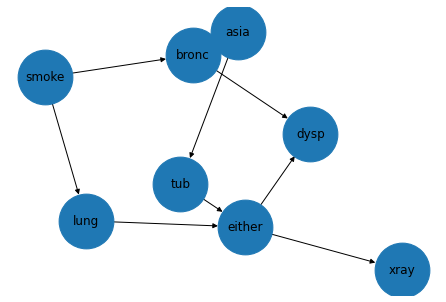

In [7]:
reasoner.bn.draw_structure()

# Making some Queries

In [13]:
reasoner = copy.deepcopy(reasoner1)
reasoner.MPE(E={'tub':True, 'either': False, 'asia':True}, var=['smoke','lung'])

smoke        False
lung         False
tub           True
either       False
asia          True
p         0.049005
Name: 0, dtype: object

In [14]:
reasoner = copy.deepcopy(reasoner1)
reasoner.MAP(Q=['xray'], E={'tub':True, 'either': False, 'asia':True}, var=['smoke','lung'])

tub            True
either        False
asia           True
p         0.0539055
Name: 0, dtype: object

In [16]:
reasoner = copy.deepcopy(reasoner1)
reasoner.dsep(X=['either'], Y=['asia'], Z=['dysp','bronc','smoke'])

Variabe asia is dependent on ['tub', 'asia', 'either']
Variabe bronc is dependent on ['asia', 'either']
Variabe dysp is dependent on ['asia', 'either']
Variabe either is dependent on ['xray', 'lung', 'tub', 'asia', 'either']
Variabe lung is dependent on ['either', 'xray', 'lung', 'tub']
Variabe smoke is dependent on ['xray', 'lung', 'tub']
Variabe tub is dependent on ['asia', 'either', 'xray', 'lung', 'tub']
Variabe xray is dependent on ['either', 'xray', 'lung', 'tub']
False They are not dsep


In [30]:
reasoner = copy.deepcopy(reasoner1)
reasoner.MultiplyFactors(X=[reasoner.bn.get_cpt('lung'),reasoner.bn.get_cpt('tub')])

,smoke,lung,p
0,False,False,0.10
1,False,True,0.90
2,True,False,0.01
3,True,True,0.99


In [31]:
reasoner.sumOutVars(cpt=reasoner.bn.get_cpt('dysp') , Z=['bronc'])

,either,dysp,p
0,False,False,1.7
1,False,True,0.3
2,True,False,0.8
3,True,True,1.2


In [35]:
reasoner.marginal_dist(Q=['xray'], E={'tub':True, 'either': False, 'asia':True}, var=['smoke','lung'])

variable is:  smoke
factor_var  {'lung':    smoke   lung     p
0  False  False  0.10
1  False   True  0.90
2   True  False  0.01
3   True   True  0.99, 'smoke':    smoke    p
0  False  0.5
1   True  0.5}
variable is:  lung
factor_var  {'either':     tub   lung  either    p
4  True  False   False  1.0
6  True   True   False  0.0, 'factor 1':     lung      p
0  False  0.055
1   True  0.945}


,tub,either,asia,p
0,True,False,True,0.055
